### Predict Life Expectancy

Governments, research institutes, and organizations like the United Nations and the World Bank try to
understand the relationship between the life expectancy of a country or a geographical area and
socioeconomic factors. Such analysis is valuable in deciding economic and social policies. Can you
construct a reliable model that predicts the life expectancy of an area (country, region, group of
countries) using socioeconomic variables and identify how different features influence that?

Every row of the train_data or the test_data represents socioeconomic variables of a geographical
area. That area could be a country, a group of countries, a region or a big country’s provision.

### Goal:

For every row in the test data, you must predict the value of the life expectancy. The predictions must
be saved in a .csv file with the name ‘submission.csv’.

The CSV file must have two columns.

    The first column must be the index of the test set
    The second column must have the predicted value of every corresponding index value.

### Evaluation Metric:

The metric used for evaluating the performance of the predictive model will be the mean absolute
error of the predictions from the ground truth (the real values of the life expectancy for every row in
the test set).

For more information please refer to the PDF file uploaded in this repo.

In [1]:
# --- Core Libraries ---
import numpy as np 
import pandas as pd  
import seaborn as sns 
import matplotlib.pyplot as plt  

# --- Scikit-learn: Preprocessing & Feature Engineering ---
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder  

# --- Scikit-learn: Missing Data Imputation ---
from sklearn.impute import SimpleImputer, KNNImputer 

# --- Scikit-learn: Data Splitting & Validation ---
from sklearn.model_selection import ParameterGrid, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# --- Scikit-learn: Regression Models ---
from sklearn.ensemble import RandomForestRegressor 

# --- Scikit-learn: Evaluation Metrics ---
from sklearn.metrics import mean_absolute_error,  r2_score              

# --- Pandas Display Options ---
pd.set_option("display.max_columns", 101)

Column | Description
:---|:---
`surface_area` | The total area in square kilometers
`agricultural_land` | The agricultural land of the total area in square kilometers 
`forest_area` | The forest area in the total area in square kilometers
`armed_forces_total` | The count of armed forces paid by this geographical area
`urban_pop_major_cities` | The percent of the total population dwelling in major cities
`urban_pop_minor_cities` | The percent of the total population dwelling in minor cities
`national_income` | National Income as an ordinal categorical variable
`inflation_annual` | Yearly Inflation Rate
`inflation_monthly` | Average Monthly Inflation Rate = annual inflation/12
`inflation_weekly` | Average Weekly Inflation Rate = annual inflation/52
`mobile_subscriptions` | Describes the number of mobile subscriptions per person 
`internet_users` | The average number of people using the internet in a range of 100 or 1000 people
`secure_internet_servers_total` | The actual number of secure internet servers in the area
`improved_sanitation` | The known access of the population to improved sanitation facilities
`women_parliament_seats_rate ` | Describes the percent range of parliament seats occupied by women
`life_expectancy` | Years of life an average person is expected to live in this area (target variable).

### Data Cleaning and Visualization 

In [2]:
# Load dataset into a DataFrame; use first column as index instead of default integer index.
df = pd.read_csv("train.csv", index_col=0)  

# Convert all column names to lowercase for consistency.
df.columns = df.columns.str.lower()  

# Replace spaces with underscores for easier column referencing.
df.columns = df.columns.str.replace(" ", "_")  

# Show first 5 rows (IPython/Jupyter-friendly display).
display(df.head())  

# Output dataset dimensions as (n_rows, n_columns).
print(df.shape)  

# Show data type for each column.
print(df.dtypes)  

# Display descriptive statistics for numeric columns.
display(df.describe())  

,surface_area,agricultural_land,forest_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,inflation_monthly,inflation_weekly,mobile_subscriptions,internet_users,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy
0,120540.0,2.632839e+06,5.417843e+06,1379000.0,55.747169,4.688831,unknown,NaN,NaN,NaN,less than 1 per person,0 per 1000 people,NaN,high access,[0%-25%),69.494195
1,752610.0,2.403039e+07,4.957554e+07,16500.0,16.890687,23.136313,very low,NaN,0.581473,NaN,less than 1 per person,154 per 1000 people,2.623624e+06,low access,[0%-25%),59.237366
2,1396.0,3.000000e+03,8.000000e+01,NaN,18.390090,23.139910,unknown,NaN,NaN,NaN,more than 1 per person,90 per 100 people,1.656589e+09,no info,unknown,81.300000
3,2758812.0,1.228845e+08,1.050943e+08,1518650.0,50.966885,24.522427,high,1.374906,NaN,NaN,more than 1 per person,76 per 100 people,6.625072e+08,very high access,[25%-50%),81.373197
4,340.0,1.100000e+04,1.699000e+04,NaN,5.311885,30.271115,unknown,-0.044229,NaN,NaN,more than 1 per person,350 per 1000 people,2.832808e+07,very high access,[25%-50%),73.193561


(362, 16)
surface_area                     float64
agricultural_land                float64
forest_area                      float64
armed_forces_total               float64
urban_pop_major_cities           float64
urban_pop_minor_cities           float64
national_income                   object
inflation_annual                 float64
inflation_monthly                float64
inflation_weekly                 float64
mobile_subscriptions              object
internet_users                    object
secure_internet_servers_total    float64
improved_sanitation               object
women_parliament_seats_rate       object
life_expectancy                  float64
dtype: object


,surface_area,agricultural_land,forest_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,inflation_annual,inflation_monthly,inflation_weekly,secure_internet_servers_total,life_expectancy
count,3.620000e+02,3.580000e+02,3.570000e+02,3.180000e+02,360.000000,360.000000,146.000000,156.000000,20.000000,3.520000e+02,362.000000
mean,4.021884e+06,1.594881e+08,1.204151e+08,9.849864e+05,27.659456,29.175242,1.681539,0.475969,0.396478,2.949654e+08,71.059691
std,1.234491e+07,4.964143e+08,3.796623e+08,2.994686e+06,20.512885,21.206494,0.980308,0.153430,0.203583,7.234006e+08,8.332818
min,3.030000e+01,3.000000e+02,0.000000e+00,5.000000e+01,0.091444,0.074575,-2.372263,0.250543,0.209993,4.002500e+04,48.850634
25%,2.783000e+04,1.054198e+06,4.951445e+05,1.218000e+04,10.624625,11.013743,1.202953,0.347799,0.232118,3.468446e+06,65.469854
50%,2.037745e+05,5.360256e+06,3.928535e+06,5.352500e+04,24.459439,26.735127,1.762683,0.459790,0.297938,2.671228e+07,73.238024
75%,1.081610e+06,4.221935e+07,2.241297e+07,2.598000e+05,38.587177,43.499418,2.485675,0.577340,0.537541,2.173937e+08,77.125610
max,1.343253e+08,5.067600e+09,4.132117e+09,2.720662e+07,92.409069,89.142904,2.997694,0.810152,0.781527,8.207343e+09,83.480488


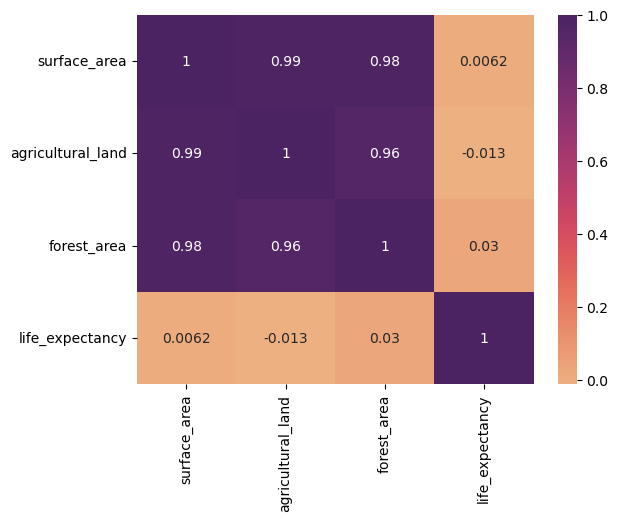

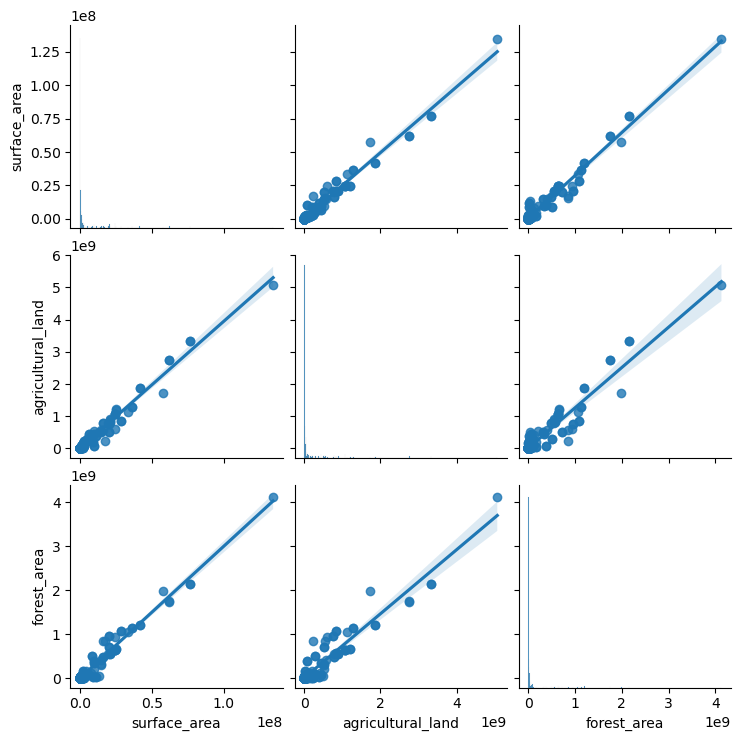

In [3]:
# Compute and display the correlation matrix for selected columns using a heatmap.
sns.heatmap(df[['surface_area', 'agricultural_land', 'forest_area', 'life_expectancy']].corr(), cmap="flare", annot=True)

# Create pairwise scatter plots (with regression lines) for selected columns to visualize relationships.
sns.pairplot(df[['surface_area', 'agricultural_land', 'forest_area']], kind='reg')

***There are strong linear relashionships among 'surface_area', 'agricultural_land', and 'forest_area'.***
Therefore, having these three variables altogether will not help (provide additional information) future prediction. To resolve this 
problem the following steps are taken:  <br>
1) Multiply 'surface_area' by 100 (to fix data entry/unit issue).  <br>
2) Create two new features (colums) namely 'agricultural_portion' and 'forest_portion' by dividing
   'agricultural_land' and 'forest_area' by 'surface_area' respectively.  <br>
3) Remove 'agricultural_land' and 'forest_area' colums from dataset.

In [4]:
# Make a deep copy of the original DataFrame so changes won't affect it.
df1 = df.copy()  

# Scale surface_area by 100 (e.g., unit conversion if needed).
df1['surface_area'] = df1['surface_area'] * 100  

# Create a new feature: proportion of agricultural land relative to total surface area.
df1['agricultural_portion'] = df1['agricultural_land'] / df1['surface_area']  

# Create a new feature: proportion of forest area relative to total surface area.
df1['forest_portion'] = df1['forest_area'] / df1['surface_area']  

# Remove original absolute value columns to keep only proportions for cleaner data.
df1.drop(['agricultural_land', 'forest_area'], axis=1, inplace=True)  

# Display the first 5 rows of the transformed DataFrame to verify changes.
display(df1.head())  

,surface_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,inflation_monthly,inflation_weekly,mobile_subscriptions,internet_users,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy,agricultural_portion,forest_portion
0,12054000.0,1379000.0,55.747169,4.688831,unknown,NaN,NaN,NaN,less than 1 per person,0 per 1000 people,NaN,high access,[0%-25%),69.494195,0.218420,0.449464
1,75261000.0,16500.0,16.890687,23.136313,very low,NaN,0.581473,NaN,less than 1 per person,154 per 1000 people,2.623624e+06,low access,[0%-25%),59.237366,0.319294,0.658715
2,139600.0,NaN,18.390090,23.139910,unknown,NaN,NaN,NaN,more than 1 per person,90 per 100 people,1.656589e+09,no info,unknown,81.300000,0.021490,0.000573
3,275881200.0,1518650.0,50.966885,24.522427,high,1.374906,NaN,NaN,more than 1 per person,76 per 100 people,6.625072e+08,very high access,[25%-50%),81.373197,0.445426,0.380940
4,34000.0,NaN,5.311885,30.271115,unknown,-0.044229,NaN,NaN,more than 1 per person,350 per 1000 people,2.832808e+07,very high access,[25%-50%),73.193561,0.323529,0.499706


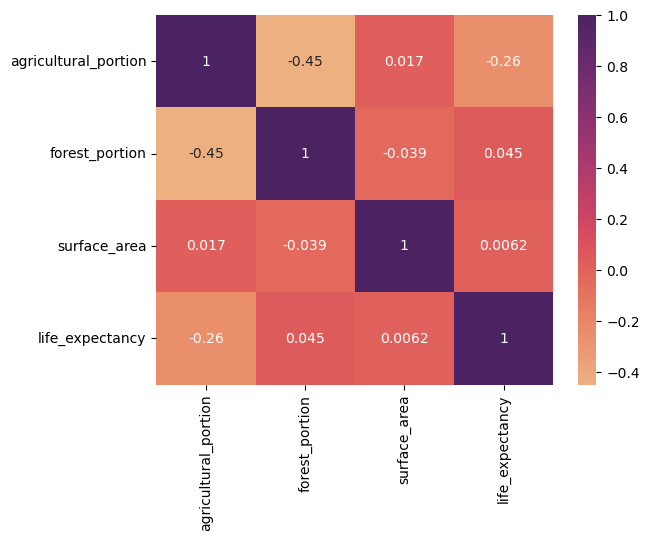

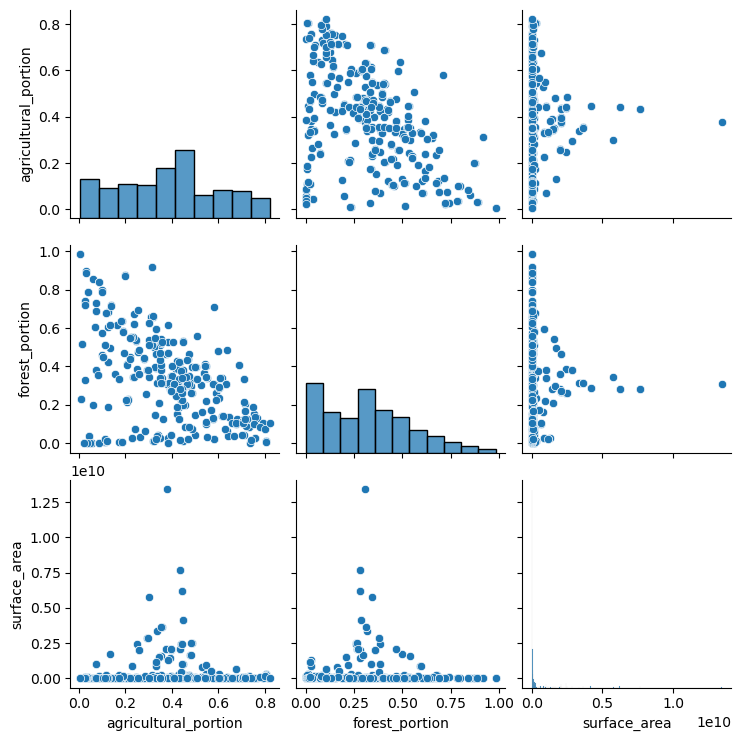

In [5]:
# Compute and display the correlation matrix for engineered features using a heatmap.
sns.heatmap(df1[['agricultural_portion', 'forest_portion', 'surface_area', 'life_expectancy']].corr(), cmap="flare", annot=True)

# Create pairwise scatter plots for engineered features to visualize relationships.
sns.pairplot(df1[['agricultural_portion', 'forest_portion', 'surface_area']], kind='scatter')

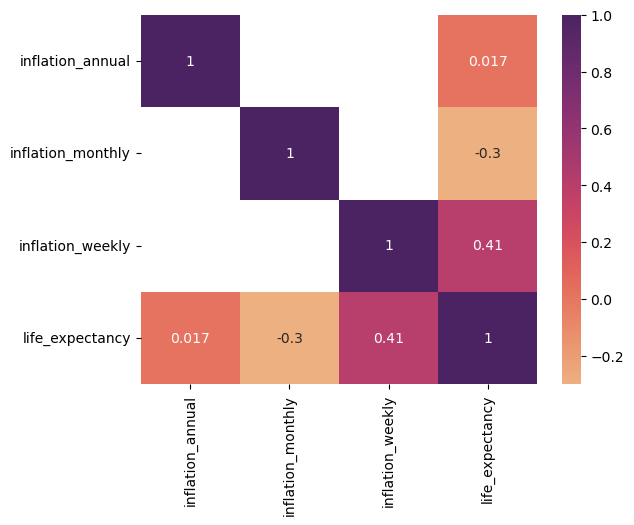

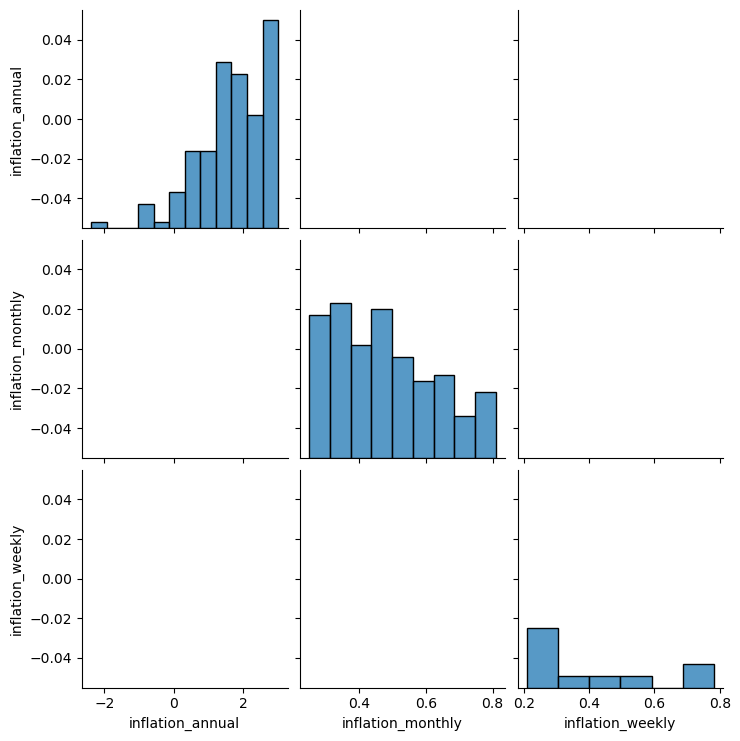

In [6]:
# Compute and display the correlation matrix for inflation features and life expectancy using a heatmap.
sns.heatmap(df1[['inflation_annual', 'inflation_monthly', 'inflation_weekly', 'life_expectancy']].corr(), cmap="flare", annot=True)

# Create pairwise scatter plots for inflation features to visualize relationships.
sns.pairplot(df1[['inflation_annual', 'inflation_monthly', 'inflation_weekly']], kind='scatter')

**The variable description indicates 'inflation_annual', 'inflation_monthly', and 'inflarion_weekly' are linearly dependent.**  <br> Therefore, we will keep only 'inflation_annual' column and replace NaN values using information from the other two features (if possible).

In [7]:
# Print the number of missing values in each column of the DataFrame.
print(df1.isnull().sum())

# Count the number of rows where all three inflation columns are missing.
missing_inflation_count = len(df1[(df1['inflation_annual'].isnull()) & 
                                   (df1['inflation_monthly'].isnull()) & 
                                   (df1['inflation_weekly'].isnull())])

# Print the count of rows with missing inflation data.
print(missing_inflation_count)

# Make a copy of the DataFrame for filling missing annual inflation values.
df2 = df1.copy()

# Fill missing 'inflation_annual' values using monthly or weekly data.
for i in df2.index:
    if np.isnan(df2.loc[i, 'inflation_annual']):
        # Use weekly inflation if monthly is also missing.
        if np.isnan(df2.loc[i, 'inflation_monthly']):
            df2.loc[i, 'inflation_annual'] = 52 * df2.loc[i, 'inflation_weekly']  # 52 weeks in a year
        else:
            # Otherwise, use monthly data to estimate annual inflation.
            df2.loc[i, 'inflation_annual'] = 12 * df2.loc[i, 'inflation_monthly']  # 12 months in a year

# Drop the original monthly and weekly inflation columns after filling annual values.
df2.drop(['inflation_monthly', 'inflation_weekly'], axis=1, inplace=True)

# Verify that all missing values are filled by printing missing counts per column.
print(df2.isnull().sum())

surface_area                       0
armed_forces_total                44
urban_pop_major_cities             2
urban_pop_minor_cities             2
national_income                    0
inflation_annual                 216
inflation_monthly                206
inflation_weekly                 342
mobile_subscriptions               0
internet_users                     0
secure_internet_servers_total     10
improved_sanitation                0
women_parliament_seats_rate        0
life_expectancy                    0
agricultural_portion               4
forest_portion                     5
dtype: int64
40
surface_area                      0
armed_forces_total               44
urban_pop_major_cities            2
urban_pop_minor_cities            2
national_income                   0
inflation_annual                 40
mobile_subscriptions              0
internet_users                    0
secure_internet_servers_total    10
improved_sanitation               0
women_parliament_seats_rate     

**There are too many categories in 'internet_users'. It's more simillar to a numeric feature! Let's check...**

In [8]:
# Inspect the 'internet_users' column to check its content and format.
# Example format might be: "50 % of population".
print(df2['internet_users'])

# Split each string in 'internet_users' by whitespace into components.
# Returns a Series of lists, e.g., "50 % of population" → ['50', '%', 'of', 'population'].
variable_split = df2['internet_users'].str.split()

# Extract numeric values and calculate percentage of internet users.
# First element is numerator, third element is denominator; convert to numeric, coerce errors to NaN.
df2['percent_internet_users'] = pd.to_numeric(variable_split.str.get(0), errors='coerce') / pd.to_numeric(variable_split.str.get(2), errors='coerce')

# Display the new 'percent_internet_users' column to verify calculation.
print(df2['percent_internet_users'])

# Remove the original 'internet_users' column as it's no longer needed.
df2.drop('internet_users', axis=1, inplace=True)
display(df2.head(10))

0        0 per 1000 people
1      154 per 1000 people
2        90 per 100 people
3        76 per 100 people
4      350 per 1000 people
              ...         
457      90 per 100 people
458      84 per 100 people
459      58 per 100 people
460      44 per 100 people
461      45 per 100 people
Name: internet_users, Length: 362, dtype: object
0      0.000
1      0.154
2      0.900
3      0.760
4      0.350
       ...  
457    0.900
458    0.840
459    0.580
460    0.440
461    0.450
Name: percent_internet_users, Length: 362, dtype: float64


,surface_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,mobile_subscriptions,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy,agricultural_portion,forest_portion,percent_internet_users
0,1.205400e+07,1379000.0,55.747169,4.688831,unknown,NaN,less than 1 per person,NaN,high access,[0%-25%),69.494195,0.218420,0.449464,0.000
1,7.526100e+07,16500.0,16.890687,23.136313,very low,6.977676,less than 1 per person,2.623624e+06,low access,[0%-25%),59.237366,0.319294,0.658715,0.154
2,1.396000e+05,NaN,18.390090,23.139910,unknown,NaN,more than 1 per person,1.656589e+09,no info,unknown,81.300000,0.021490,0.000573,0.900
3,2.758812e+08,1518650.0,50.966885,24.522427,high,1.374906,more than 1 per person,6.625072e+08,very high access,[25%-50%),81.373197,0.445426,0.380940,0.760
4,3.400000e+04,NaN,5.311885,30.271115,unknown,-0.044229,more than 1 per person,2.832808e+07,very high access,[25%-50%),73.193561,0.323529,0.499706,0.350
5,7.835600e+07,612800.0,37.699524,34.134476,medium low,8.891570,less than 1 per person,1.166004e+08,very high access,[0%-25%),74.862439,0.499032,0.148224,0.450
6,2.846040e+09,5032780.0,32.853558,37.469387,medium high,2.773339,more than 1 per person,4.702241e+08,very high access,[0%-25%),76.569368,0.294847,0.379839,0.640
7,5.490910e+07,325600.0,24.582761,54.237239,high,1.955685,less than 1 per person,4.093085e+08,very high access,[25%-50%),81.968293,0.526820,0.304076,0.810
8,3.571700e+07,186450.0,18.091168,56.596832,high,2.008491,more than 1 per person,1.110775e+09,very high access,[25%-50%),80.892683,0.478109,0.327452,0.820
10,7.160000e+04,147600.0,51.288344,48.711656,unknown,4.528651,more than 1 per person,6.353061e+08,very high access,[0%-25%),81.995122,0.010340,0.231586,0.720


In [9]:
# Inspect all categorical columns (dtype 'object') and display counts of unique values.
for name in df2.select_dtypes(include=['object']):
    print(name, ':')  # Print the column name
    print(df2[name].value_counts(), '\n')  # Print counts of unique values for quick inspection

# Map 'national_income' textual categories to ordered numeric codes.
mapper1 = {'very low':1, 'medium low':2, 'low':3, 'medium high':4, 'high':5, 'very high':6, 'unknown':7}
df2['national_income'].replace(mapper1, inplace=True)

# Encode 'mobile_subscriptions' as binary numeric: 1 = 'less than 1 person', 2 = all other categories.
df2['mobile_subscriptions'] = [1 if x == 'less than 1 person' else 2 for x in df2['mobile_subscriptions']]

# Map 'improved_sanitation' textual categories to ordered numeric codes.
mapper2 = {'very low access':1, 'low access':2, 'medium access':3, 'high access':4, 'very high access':5, 'no info':6}
df2['improved_sanitation'].replace(mapper2, inplace=True)

# Encode 'women_parliament_seats_rate' ranges as numeric codes.
# 1 = [0%-25%), 2 = [25%-75%), 3 = unknown
df2['women_parliament_seats_rate'] = df2['women_parliament_seats_rate'].replace('[0%-25%)', 1)
df2['women_parliament_seats_rate'] = df2['women_parliament_seats_rate'].replace('[25%-50%)', 2)
df2['women_parliament_seats_rate'] = df2['women_parliament_seats_rate'].replace('[50%-75%)', 2)
df2['women_parliament_seats_rate'] = df2['women_parliament_seats_rate'].replace('unknown', 3)

# Display the dataframe
display(df2.head(10))

national_income :
national_income
low            81
very low       77
medium low     76
unknown        48
high           37
medium high    31
very high      12
Name: count, dtype: int64 

mobile_subscriptions :
mobile_subscriptions
more than 1 per person    188
less than 1 per person    164
unknown                     7
more than 2 per person      2
more than 3 per person      1
Name: count, dtype: int64 

improved_sanitation :
improved_sanitation
very high access    155
low access           55
medium access        54
high access          47
very low access      33
no info              18
Name: count, dtype: int64 

women_parliament_seats_rate :
women_parliament_seats_rate
[0%-25%)     249
[25%-50%)     82
unknown       30
[50%-75%)      1
Name: count, dtype: int64 



C:\Users\AliPe\AppData\Local\Temp\ipykernel_36560\3663911746.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['national_income'].replace(mapper1, inplace=True)
C:\Users\AliPe\AppData\Local\Temp\ipykernel_36560\3663911746.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['national_income

,surface_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,mobile_subscriptions,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy,agricultural_portion,forest_portion,percent_internet_users
0,1.205400e+07,1379000.0,55.747169,4.688831,7,NaN,2,NaN,4,1,69.494195,0.218420,0.449464,0.000
1,7.526100e+07,16500.0,16.890687,23.136313,1,6.977676,2,2.623624e+06,2,1,59.237366,0.319294,0.658715,0.154
2,1.396000e+05,NaN,18.390090,23.139910,7,NaN,2,1.656589e+09,6,3,81.300000,0.021490,0.000573,0.900
3,2.758812e+08,1518650.0,50.966885,24.522427,5,1.374906,2,6.625072e+08,5,2,81.373197,0.445426,0.380940,0.760
4,3.400000e+04,NaN,5.311885,30.271115,7,-0.044229,2,2.832808e+07,5,2,73.193561,0.323529,0.499706,0.350
5,7.835600e+07,612800.0,37.699524,34.134476,2,8.891570,2,1.166004e+08,5,1,74.862439,0.499032,0.148224,0.450
6,2.846040e+09,5032780.0,32.853558,37.469387,4,2.773339,2,4.702241e+08,5,1,76.569368,0.294847,0.379839,0.640
7,5.490910e+07,325600.0,24.582761,54.237239,5,1.955685,2,4.093085e+08,5,2,81.968293,0.526820,0.304076,0.810
8,3.571700e+07,186450.0,18.091168,56.596832,5,2.008491,2,1.110775e+09,5,2,80.892683,0.478109,0.327452,0.820
10,7.160000e+04,147600.0,51.288344,48.711656,7,4.528651,2,6.353061e+08,5,1,81.995122,0.010340,0.231586,0.720


#### Handling Missing Data

In [10]:
# Make a copy of df2 for imputation to avoid modifying the original DataFrame.
df3 = df2.copy()

# Print the count of missing values per column, sorted descending to identify columns with most NaNs.
print(df2.isnull().sum().sort_values(ascending=False))

# Create a SimpleImputer object to fill missing values using the median of each column.
imp = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit the imputer on the DataFrame to compute median values for each column.
imp.fit(df3)

# Transform the DataFrame by filling missing values and convert the result back to a DataFrame.
df3 = pd.DataFrame(data=imp.transform(df3), columns=df3.columns)

# Display the first 10 rows to verify that missing values have been filled.
display(df3.head(10))

armed_forces_total               44
inflation_annual                 40
secure_internet_servers_total    10
percent_internet_users            6
forest_portion                    5
agricultural_portion              4
urban_pop_major_cities            2
urban_pop_minor_cities            2
national_income                   0
surface_area                      0
women_parliament_seats_rate       0
improved_sanitation               0
mobile_subscriptions              0
life_expectancy                   0
dtype: int64


,surface_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,mobile_subscriptions,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy,agricultural_portion,forest_portion,percent_internet_users
0,1.205400e+07,1379000.0,55.747169,4.688831,7.0,3.371067,2.0,2.671228e+07,4.0,1.0,69.494195,0.218420,0.449464,0.000
1,7.526100e+07,16500.0,16.890687,23.136313,1.0,6.977676,2.0,2.623624e+06,2.0,1.0,59.237366,0.319294,0.658715,0.154
2,1.396000e+05,53525.0,18.390090,23.139910,7.0,3.371067,2.0,1.656589e+09,6.0,3.0,81.300000,0.021490,0.000573,0.900
3,2.758812e+08,1518650.0,50.966885,24.522427,5.0,1.374906,2.0,6.625072e+08,5.0,2.0,81.373197,0.445426,0.380940,0.760
4,3.400000e+04,53525.0,5.311885,30.271115,7.0,-0.044229,2.0,2.832808e+07,5.0,2.0,73.193561,0.323529,0.499706,0.350
5,7.835600e+07,612800.0,37.699524,34.134476,2.0,8.891570,2.0,1.166004e+08,5.0,1.0,74.862439,0.499032,0.148224,0.450
6,2.846040e+09,5032780.0,32.853558,37.469387,4.0,2.773339,2.0,4.702241e+08,5.0,1.0,76.569368,0.294847,0.379839,0.640
7,5.490910e+07,325600.0,24.582761,54.237239,5.0,1.955685,2.0,4.093085e+08,5.0,2.0,81.968293,0.526820,0.304076,0.810
8,3.571700e+07,186450.0,18.091168,56.596832,5.0,2.008491,2.0,1.110775e+09,5.0,2.0,80.892683,0.478109,0.327452,0.820
9,7.160000e+04,147600.0,51.288344,48.711656,7.0,4.528651,2.0,6.353061e+08,5.0,1.0,81.995122,0.010340,0.231586,0.720


## Visualization, Modeling, Machine Learning

 Can you construct a reliable model that predicts the life expectancy of an area (country, region, group of countries) using socioeconomic variables and identify how different features influence their decision? Please explain your findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model would be evaluated on the basis of Mean Absolute Error.**
- **Read the Test.csv file and prepare features for testing.**

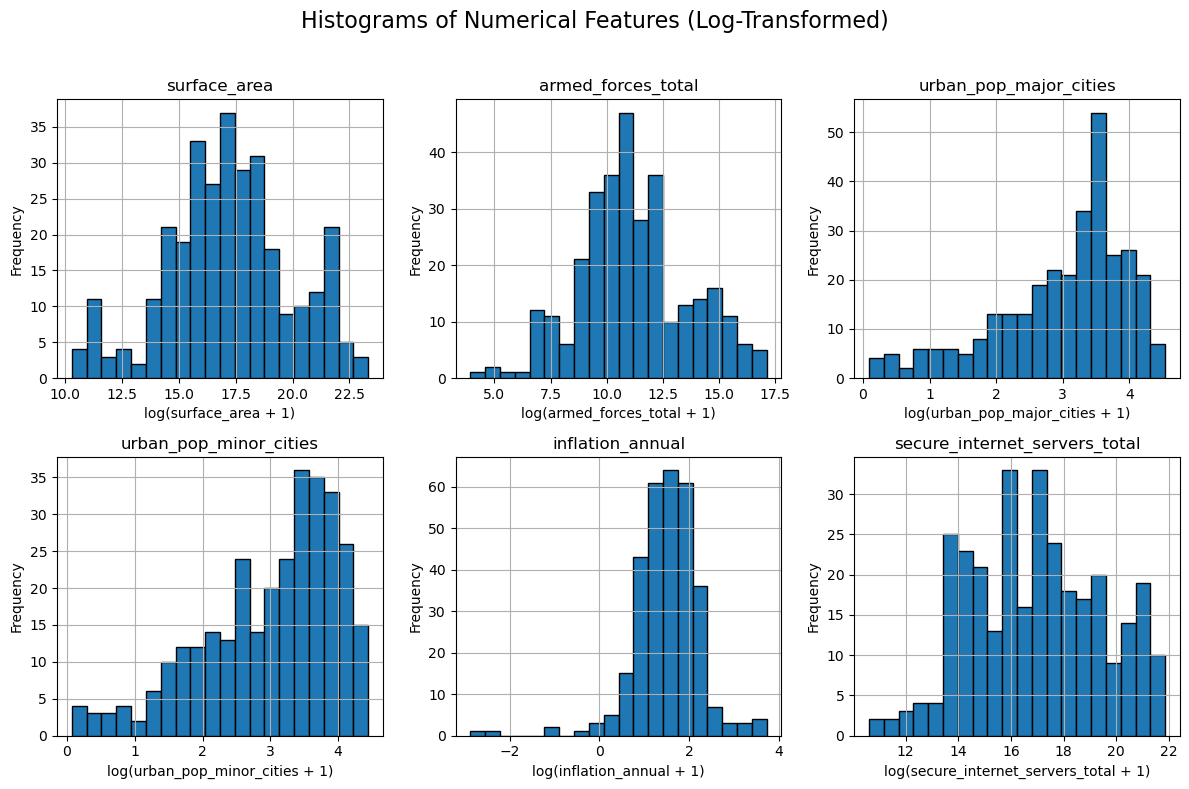

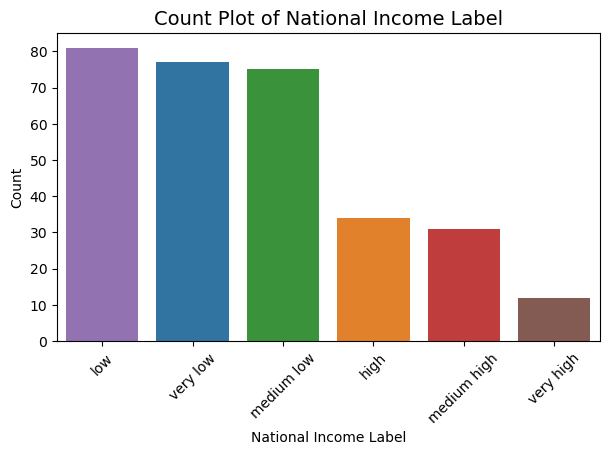

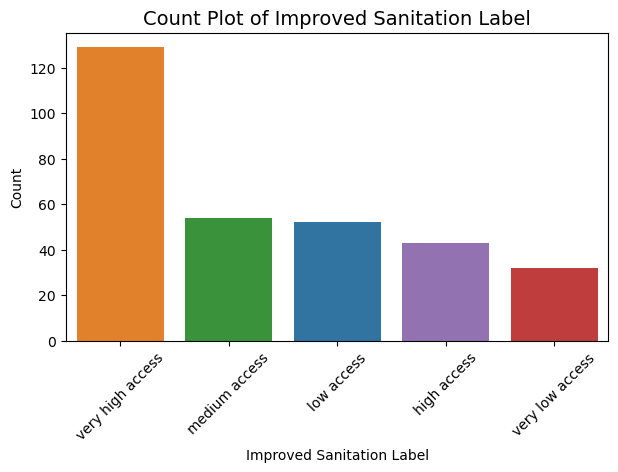

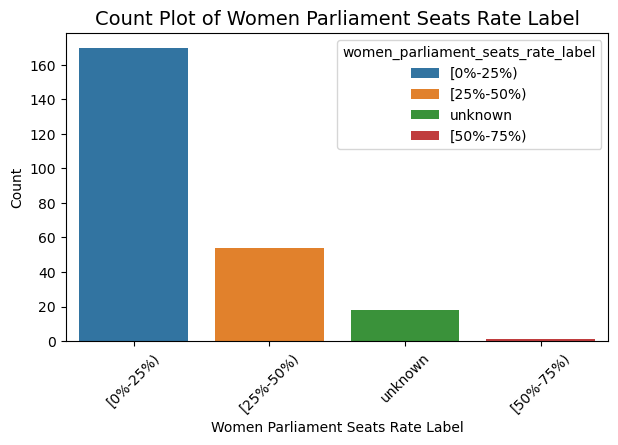

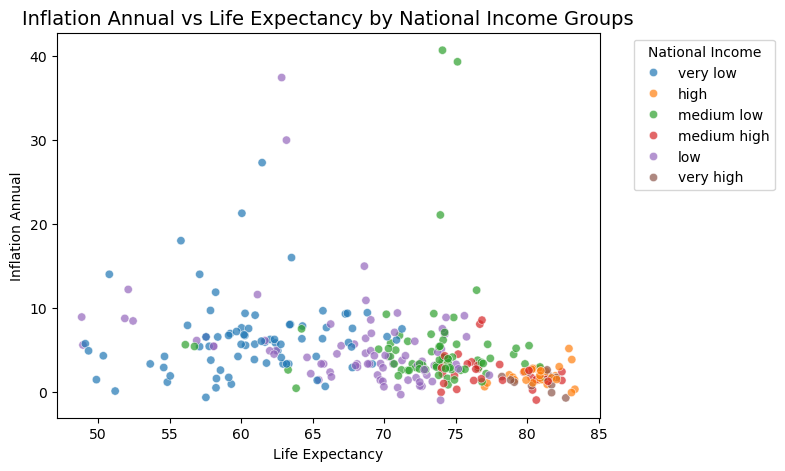

In [11]:
# ===================================
# Data Preparation for Visualization
# ===================================

# Make a copy of the main dataset for visualization purposes.
df4 = df3.copy()

# Map numeric codes back to descriptive labels for better readability in plots.

# National Income
inverse_mapper1 = {1:'very low', 2:'medium low', 3:'low', 4:'medium high', 5:'high', 6:'very high', 7:'unknown'}
df4['national_income_label'] = df4['national_income'].map(inverse_mapper1)

# Mobile Subscriptions
df4['mobile_subscriptions_label'] = df4['mobile_subscriptions'].map({1:'less than 1 person', 2:'more than 1 person'})

# Improved Sanitation
inverse_mapper2 = {1:'very low access', 2:'low access', 3:'medium access', 4:'high access', 5:'very high access', 6:'no info'}
df4['improved_sanitation_label'] = df4['improved_sanitation'].map(inverse_mapper2)

# Women in Parliament: keep original categorical ranges for readability
df4['women_parliament_seats_rate_label'] = df1['women_parliament_seats_rate']

# Filter out "unknown" and "no info" categories for cleaner visualizations
df4_filtered = df4[(~df4['national_income_label'].isin(['unknown'])) &
                   (~df4['improved_sanitation_label'].isin(['no info']))].copy()

# ===================================
# Histograms for Numerical Features (Log-Transformed)
# ===================================
# Select numeric columns to visualize
num_cols = ['surface_area', 'armed_forces_total', 'urban_pop_major_cities',
            'urban_pop_minor_cities', 'inflation_annual', 'secure_internet_servers_total']

# Apply log(x + 1) transformation to reduce skewness and handle zero values
log_df = np.log(df4_filtered[num_cols] + 1)

# Plot histograms for each numeric feature
axes = log_df.hist(bins=20, figsize=(12, 8), edgecolor='black', layout=(2, 3))

# Label axes to indicate log-transformed scale
for ax, col in zip(axes.flatten(), log_df.columns):
    ax.set_xlabel(f"log({col} + 1)")
    ax.set_ylabel("Frequency")

plt.suptitle("Histograms of Numerical Features (Log-Transformed)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ===================================
# Count Plots for Categorical Features with Original Labels
# ===================================
# List of categorical label columns to plot
cat_label_cols = ['national_income_label', 'improved_sanitation_label', 'women_parliament_seats_rate_label']

# Plot count plots for each categorical feature
for col in cat_label_cols:
    plt.figure(figsize=(7,4))
    sns.countplot(
        x=col,
        data=df4_filtered,
        order=df4_filtered[col].value_counts().index,   # Order bars by frequency
        hue=df4_filtered[col]                           # Hue reflects the category itself
    )
    plt.title(f"Count Plot of {col.replace('_', ' ').title()}", fontsize=14)
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

# ===================================
# Scatter Plot with Categorical Hue Labels
# ===================================
# Scatter plot to examine relationship between Life Expectancy and Annual Inflation
# Hue reflects National Income groups for interpretability
plt.figure(figsize=(7,5))
sns.scatterplot(
    x='life_expectancy',
    y='inflation_annual',
    data=df4_filtered,
    hue='national_income_label',  # Use descriptive labels instead of numeric codes
    alpha=0.7                     # Slight transparency to reduce point overlap
)
plt.title("Inflation Annual vs Life Expectancy by National Income Groups", fontsize=14)
plt.xlabel("Life Expectancy")
plt.ylabel("Inflation Annual")
plt.legend(title='National Income', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

c:\Users\AliPe\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


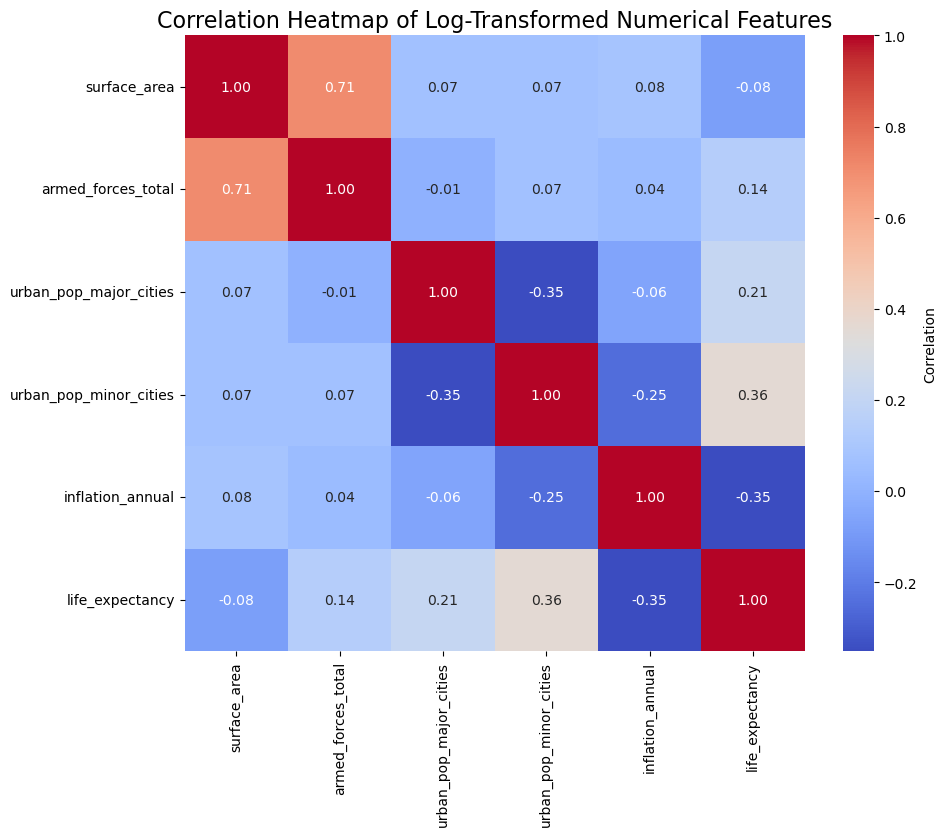

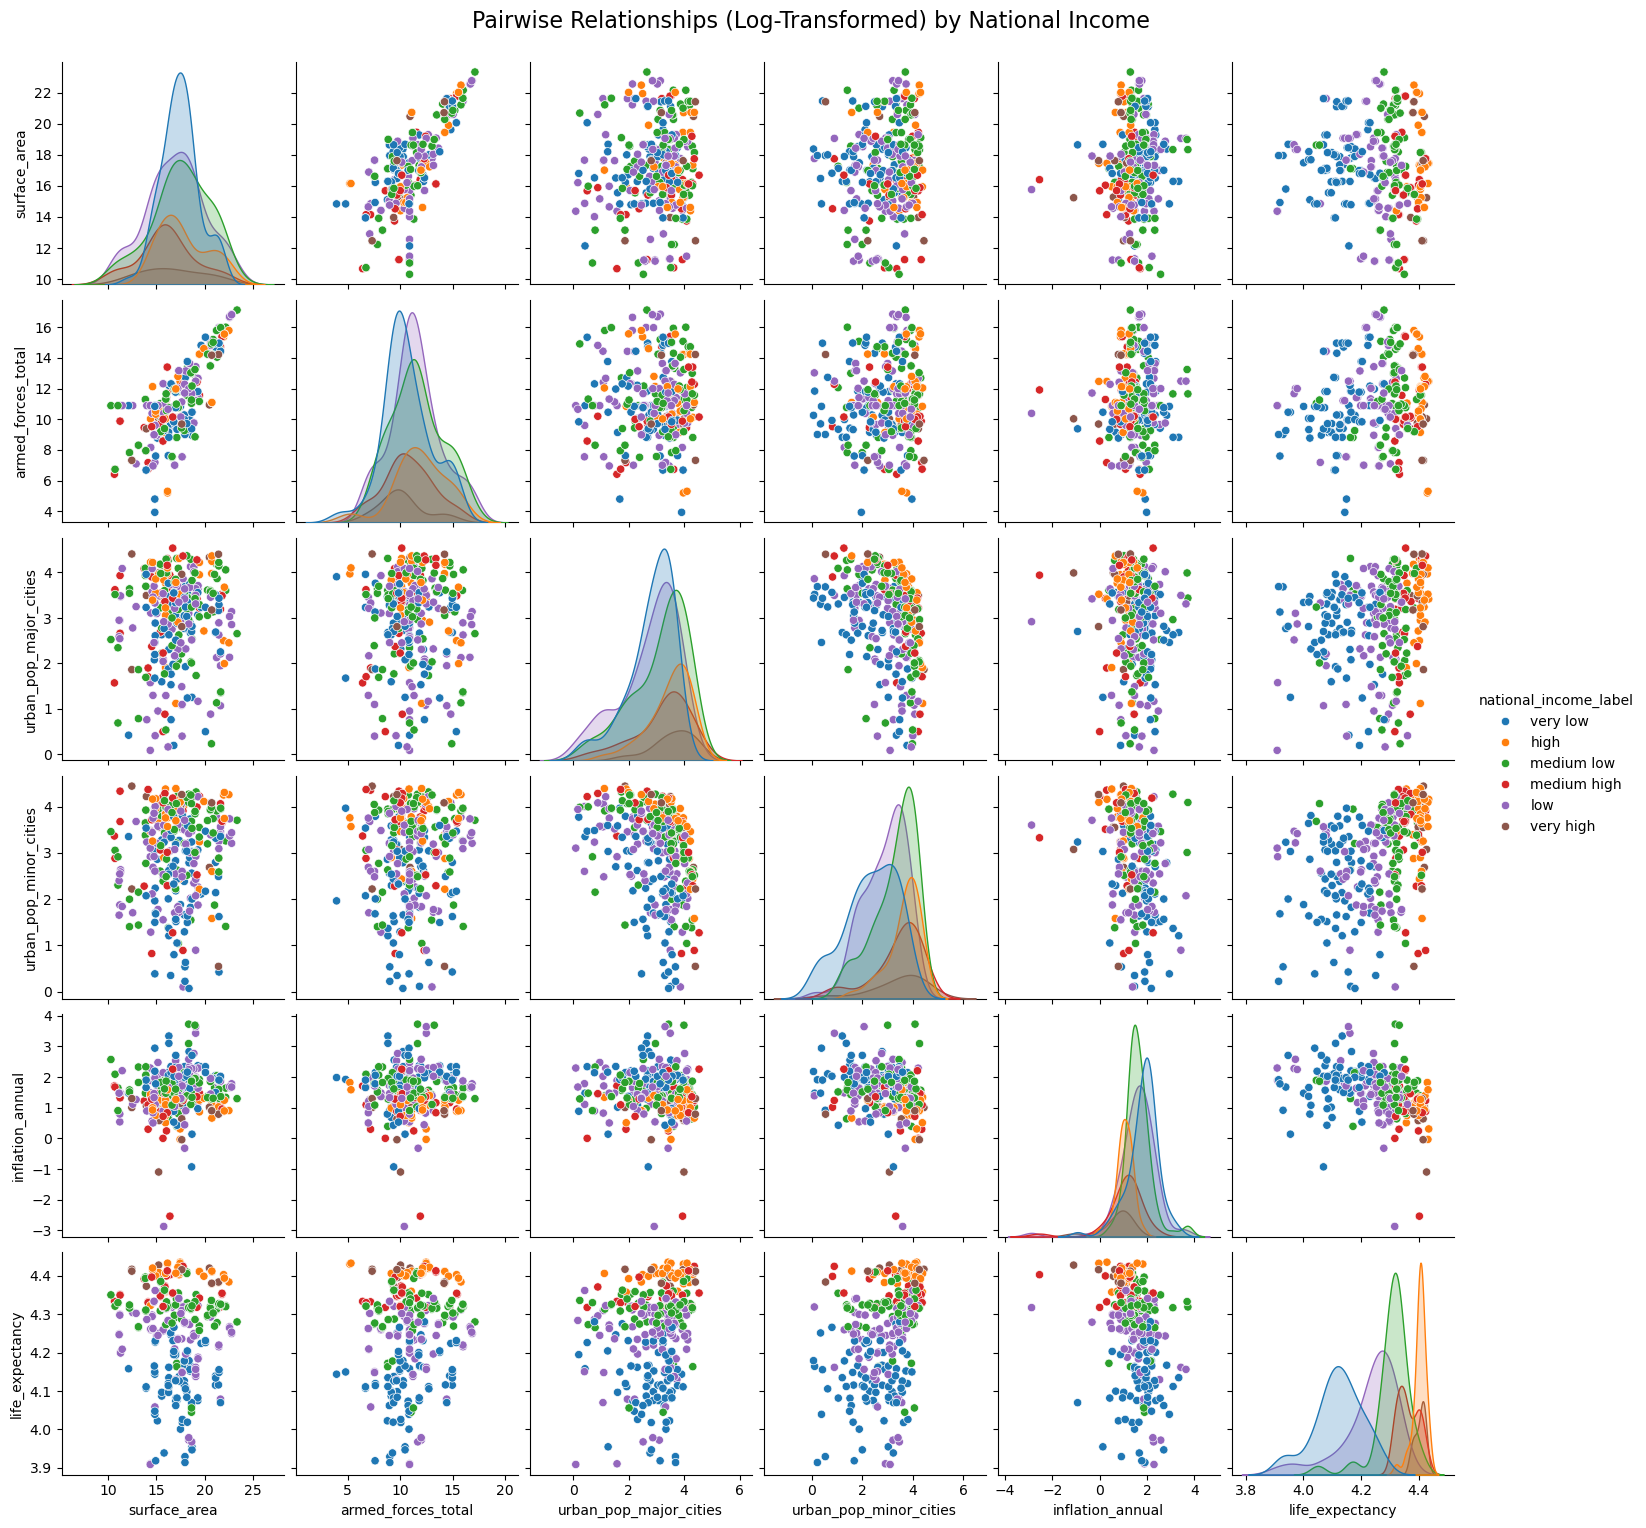

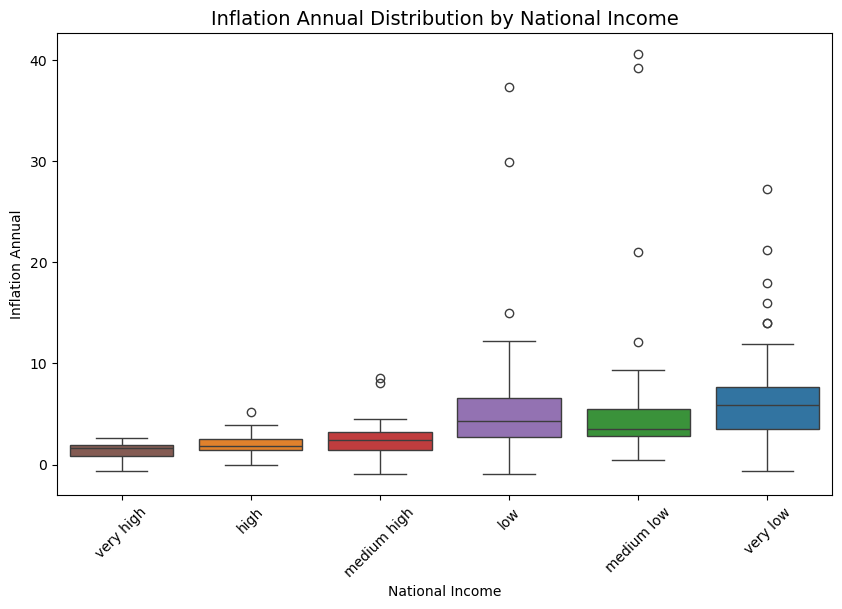

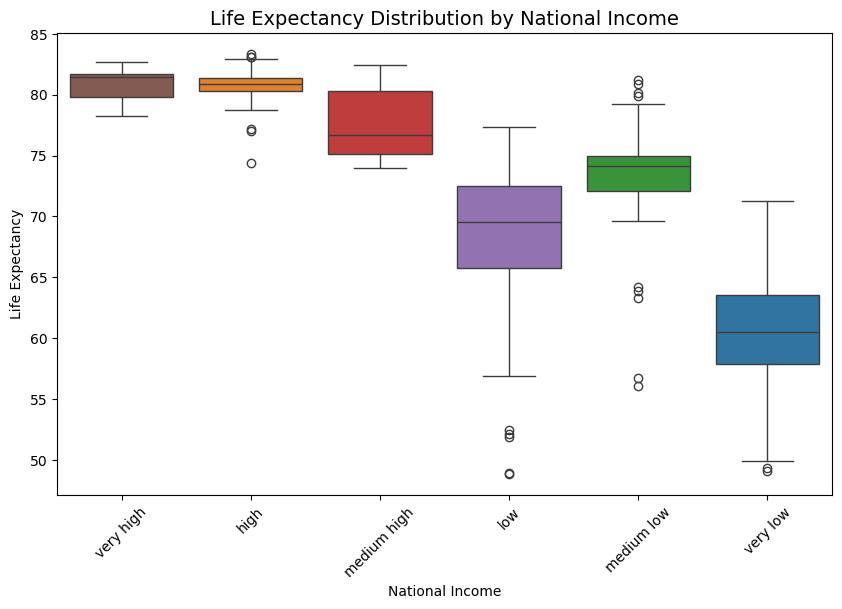

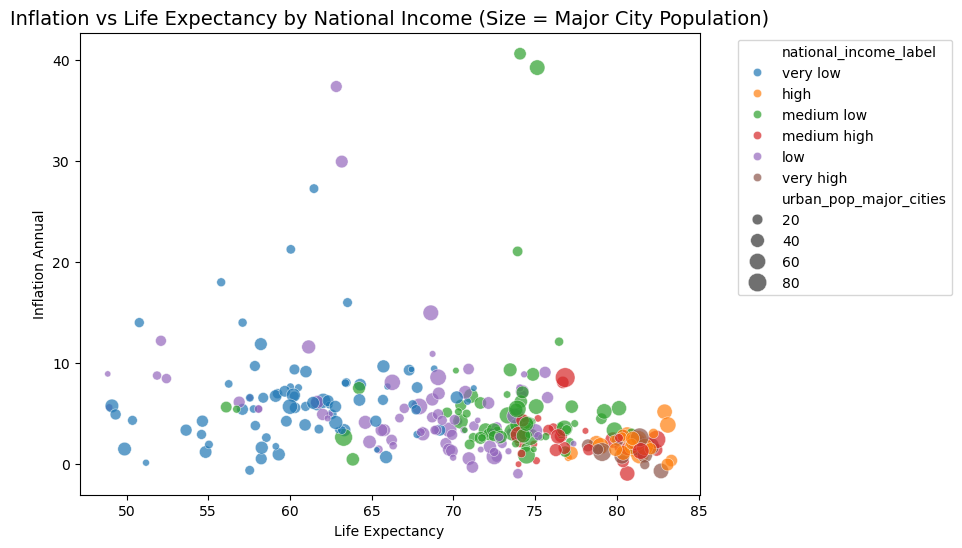

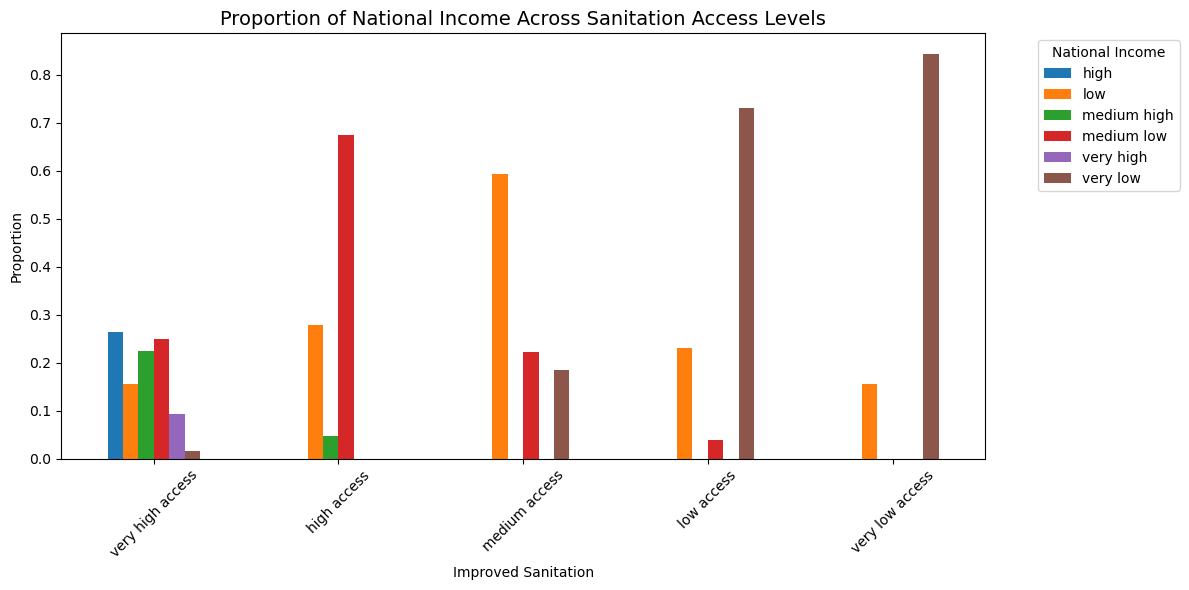

In [12]:
# Select key numerical columns for analysis
num_cols = ['surface_area', 'armed_forces_total', 'urban_pop_major_cities',
            'urban_pop_minor_cities', 'inflation_annual', 'life_expectancy']

# Make a copy and apply log(x+1) transformation to reduce skewness and handle zeros
df4_log = df4.copy()
df4_log[num_cols] = np.log1p(df4_log[num_cols])

# Filter out rows with "unknown" or "no info" categories for cleaner visualizations
df4_filtered = df4[(~df4['national_income_label'].isin(['unknown'])) &
                   (~df4['improved_sanitation_label'].isin(['no info']))].copy()

# Keep log-transformed data in sync with the filtered DataFrame
df4_log_filtered = df4_log.loc[df4_filtered.index]

# Plot correlation heatmap for log-transformed numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df4_log_filtered[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Correlation'})
plt.title("Correlation Heatmap of Log-Transformed Numerical Features", fontsize=16)
plt.show()

# Pairplot of log-transformed features colored by National Income
sns.pairplot(df4_log_filtered[num_cols + ['national_income_label']], hue='national_income_label', diag_kind='kde')
plt.suptitle("Pairwise Relationships (Log-Transformed) by National Income", y=1.02, fontsize=16)
plt.show()

# Define order of National Income categories for consistent plotting
income_order = ['very high', 'high', 'medium high', 'low', 'medium low', 'very low']

# Boxplot: Inflation Annual distribution by National Income
plt.figure(figsize=(10,6))
sns.boxplot(x='national_income_label', y='inflation_annual', data=df4_filtered, hue='national_income_label', order=income_order)
plt.title("Inflation Annual Distribution by National Income", fontsize=14)
plt.xlabel("National Income")
plt.ylabel("Inflation Annual")
plt.xticks(rotation=45)
plt.show()

# Boxplot: Life Expectancy distribution by National Income
plt.figure(figsize=(10,6))
sns.boxplot(x='national_income_label', y='life_expectancy', data=df4_filtered, hue='national_income_label', order=income_order)
plt.title("Life Expectancy Distribution by National Income", fontsize=14)
plt.xlabel("National Income")
plt.ylabel("Life Expectancy")
plt.xticks(rotation=45)
plt.show()

# Scatter plot: Life Expectancy vs Inflation Annual, sized by major city population
plt.figure(figsize=(8,6))
sns.scatterplot(x='life_expectancy', y='inflation_annual', size='urban_pop_major_cities', sizes=(20, 200), hue='national_income_label', alpha=0.7, data=df4_filtered)
plt.title("Inflation vs Life Expectancy by National Income (Size = Major City Population)", fontsize=14)
plt.xlabel("Life Expectancy")
plt.ylabel("Inflation Annual")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Grouped bar chart: Proportion of National Income across sanitation access levels
sanitation_order = ['very high access', 'high access', 'medium access', 'low access', 'very low access']

# Create cross-tabulation of sanitation access vs national income
cross_tab = pd.crosstab(df4_filtered['improved_sanitation_label'], df4_filtered['national_income_label'])
cross_tab = cross_tab.reindex(sanitation_order)  # Enforce category order
cross_tab_norm = cross_tab.div(cross_tab.sum(1), axis=0)  # Normalize to proportions

# Plot grouped bar chart
cross_tab_norm.plot(kind='bar', stacked=False, figsize=(12,6))
plt.title("Proportion of National Income Across Sanitation Access Levels", fontsize=14)
plt.xlabel("Improved Sanitation")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title='National Income', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

### Random Forest Regression

Random Forest Regression is an **ensemble learning method** that builds multiple decision trees and averages their predictions to improve accuracy and reduce overfitting.

**Target Variable:**  
- `life_expectancy`

**Predictors:**  
- All other numeric and engineered features in `X`

**Hyperparameters Tuned:**  
- **n_estimators**: Number of trees in the forest  
- **max_features**: Maximum number of features considered for each split  
- **max_depth**: Maximum depth of each tree  
- **min_samples_split**: Minimum number of samples required to split an internal node  
- **min_samples_leaf**: Minimum number of samples required at a leaf node  

**Criterion:**  
- `absolute_error` (Mean Absolute Error)

**Model Evaluation:**  
- 4-fold cross-validation using MAE to select the best hyperparameter combination

**Advantages:**  
- Robust to overfitting  
- Handles non-linear relationships  
- Works well with both categorical and continuous predictors


In [13]:
# Load the test dataset and set the first column as the index
test_data = pd.read_csv('test.csv', index_col=0)

# Make a copy of the test data for processing
tdf = test_data.copy()

# Step 1: Feature engineering on land areas
# Scale 'surface_area', calculate proportions for agricultural and forest land, then drop original columns
tdf['surface_area'] = tdf['surface_area'] * 100
tdf['agricultural_portion'] = tdf['agricultural_land'] / tdf['surface_area']
tdf['forest_portion'] = tdf['forest_area'] / tdf['surface_area']
tdf.drop(['agricultural_land', 'forest_area'], axis=1, inplace=True)

# Step 2: Fill missing annual inflation values based on monthly or weekly data
for i in tdf.index:
    # If 'inflation_annual' is missing
    if np.isnan(tdf.loc[i, 'inflation_annual']):
        # Use weekly data if monthly data is also missing
        if np.isnan(tdf.loc[i, 'inflation_monthly']):
            tdf.loc[i, 'inflation_annual'] = 52 * tdf.loc[i, 'inflation_weekly']
        else:
            # Otherwise, use monthly data
            tdf.loc[i, 'inflation_annual'] = 12 * tdf.loc[i, 'inflation_monthly']

# Drop monthly and weekly inflation columns after filling annual values
tdf.drop(['inflation_monthly', 'inflation_weekly'], axis=1, inplace=True)

# Step 3: Convert 'internet_users' strings to numeric percentage
variable_split = tdf['internet_users'].str.split()
tdf['percent_internet_users'] = (
    pd.to_numeric(variable_split.str.get(0), errors='coerce') /  # Numerator
    pd.to_numeric(variable_split.str.get(2), errors='coerce')    # Denominator
)
# Remove original 'internet_users' column
tdf.drop('internet_users', axis=1, inplace=True)

# Step 4: Encode categorical variables as numeric
# Define mappings for 'national_income' and 'improved_sanitation'
mapper1 = {'very low':1, 'medium low':2, 'low':3, 'medium high':4, 'high':5, 'very high':6, 'unknown':7}
mapper2 = {'very low access':1, 'low access':2, 'medium access':3, 'high access':4, 'very high access':5, 'no info':6}

# Encode 'mobile_subscriptions' as binary numeric
tdf['mobile_subscriptions'] = [1 if x == 'less than 1 person' else 2 for x in tdf['mobile_subscriptions']]

# Apply numeric mappings to categorical columns
tdf['national_income'].replace(mapper1, inplace=True)
tdf['improved_sanitation'].replace(mapper2, inplace=True)

# Encode 'women_parliament_seats_rate' categorical ranges as numeric
tdf['women_parliament_seats_rate'] = tdf['women_parliament_seats_rate'].replace('[0%-25%)', 1)
tdf['women_parliament_seats_rate'] = tdf['women_parliament_seats_rate'].replace('[25%-50%)', 2)
tdf['women_parliament_seats_rate'] = tdf['women_parliament_seats_rate'].replace('[50%-75%)', 2)
tdf['women_parliament_seats_rate'] = tdf['women_parliament_seats_rate'].replace('unknown', 3)

# Step 5: Impute missing values with median strategy
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(tdf)
tdf = pd.DataFrame(data=imp.transform(tdf), columns=tdf.columns)

# Display first 10 rows of processed test data
display(tdf.head(10))

# Select the target variable for modeling
y = df3['life_expectancy']

# Select all other features as predictors by dropping the target column
X = df3.drop('life_expectancy', axis=1)

# Display the first few values of the target variable to inspect
y.head()

C:\Users\AliPe\AppData\Local\Temp\ipykernel_36560\3286975163.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tdf['national_income'].replace(mapper1, inplace=True)
C:\Users\AliPe\AppData\Local\Temp\ipykernel_36560\3286975163.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tdf['national_inco

,surface_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,mobile_subscriptions,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,agricultural_portion,forest_portion,percent_internet_users
0,3.224600e+07,50800.0,0.846584,51.919416,3.0,2.569961,2.0,1849926.0,1.0,1.0,0.647799,0.327101,0.084
1,5.131200e+07,453550.0,42.139810,5.803190,3.0,2.184886,2.0,17983312.0,5.0,1.0,0.432774,0.319814,0.289
2,1.858000e+06,50800.0,1.699056,67.396944,7.0,3.009844,2.0,240458015.0,5.0,3.0,0.100766,0.458972,0.660
3,1.124900e+07,20000.0,48.602426,4.934574,3.0,5.161899,2.0,9427882.0,4.0,1.0,0.289123,0.431853,0.178
4,7.835600e+07,612800.0,43.734006,28.635994,2.0,7.493090,2.0,50379814.0,5.0,1.0,0.499240,0.149555,0.460
5,5.279700e+07,137900.0,8.744626,24.705374,1.0,3.009844,2.0,626635.0,6.0,1.0,0.445972,0.010398,0.200
6,3.000000e+04,50800.0,35.083578,8.332422,2.0,2.314011,2.0,85443065.0,5.0,1.0,0.263333,0.033333,0.440
7,1.303700e+07,12000.0,0.980363,57.165637,3.0,7.135381,2.0,8577705.0,3.0,2.0,0.420891,0.258767,0.155
8,1.315284e+09,2866760.0,16.267914,40.853782,2.0,3.160410,2.0,14444191.0,4.0,1.0,0.381331,0.028384,0.323
9,2.974000e+06,49100.0,21.673721,41.487279,3.0,2.555471,2.0,26860609.0,4.0,1.0,0.591149,0.116403,0.375


0    69.494195
1    59.237366
2    81.300000
3    81.373197
4    73.193561
Name: life_expectancy, dtype: float64

In [14]:
# Define hyperparameter grid for Random Forest Regressor
# n_estimators: number of trees in the forest
n_estimators = [100, 125, 150, 175, 200]

# max_features: number of features considered for best split
max_features = [2, 5, 7, 10, 13]

# max_depth: maximum depth of each tree
max_depth = [5, 6, 7, 8, 9, 10]

# min_samples_split: minimum number of samples required to split a node
min_split = [2, 3, 4, 5]

# min_samples_leaf: minimum number of samples required at a leaf node
min_leaf = [2, 3, 4, 5]

# Initialize best score for comparison (lower MAE is better)
best_score = 100

# Grid search over all hyperparameter combinations
for n in n_estimators:
    for f in max_features:
        for d in max_depth:
            for s in min_split:
                for l in min_leaf:
                    # Create a Random Forest Regressor with current hyperparameters
                    rf = RandomForestRegressor(
                        n_estimators=n,
                        criterion="absolute_error",  # Use Mean Absolute Error for splitting
                        max_features=f,
                        random_state=33,             # Ensure reproducibility
                        oob_score=False,             # Disable out-of-bag score
                        max_depth=d,
                        min_samples_split=s,
                        min_samples_leaf=l
                    )

                    # Fit the model on the full dataset
                    rf.fit(X, y)

                    # Make predictions on the training set (for evaluation only)
                    y_model = rf.predict(X)

                    # Evaluate model using 4-fold cross-validation and MAE
                    score = -np.mean(cross_val_score(rf, X, y, cv=4, scoring='neg_mean_absolute_error'))

                    # Update best hyperparameters if current score is lower
                    if score <= best_score:
                        best_score = score
                        max_n = n
                        max_f = f
                        max_d = d
                        max_s = s
                        max_l = l

# Print the best hyperparameters and corresponding MAE
print("Number of Estimators:", max_n)
print("Max features:", max_f)
print("Max Depth:", max_d)
print("Min Split:", max_s)
print("Min Leaf:", max_l)
print("Best Mean Absolute Error: {:.3f}".format(best_score))

Number of Estimators: 200
Max features: 7
Max Depth: 10
Min Split: 4
Min Leaf: 2
Best Mean Absolute Error: 2.563


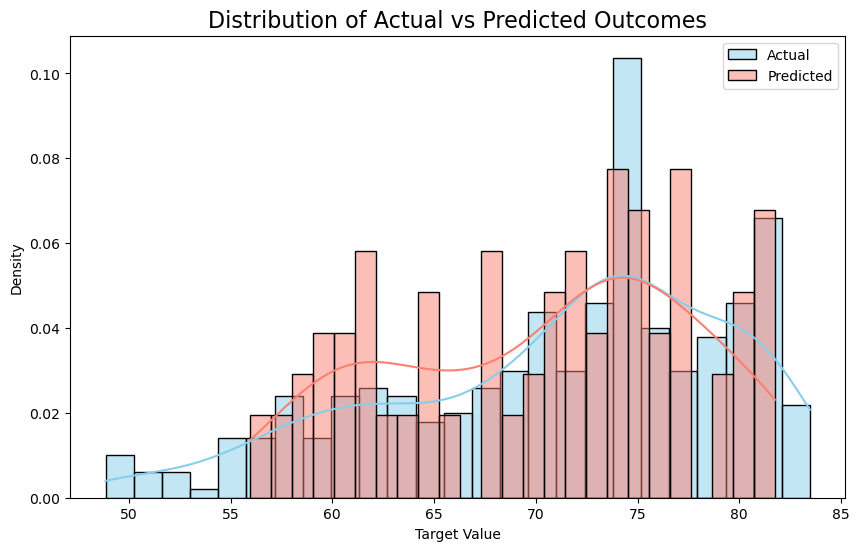

R-squared: 0.9375
Mean Absolute Error (MAE): 1.3500


In [15]:
# Function to plot improved overlapping histograms with KDE
def plot_histogram_comp(x, y):
    """
    Plots overlapping histograms of actual vs predicted values with KDE overlay.
    
    Parameters:
    x : array-like
        Actual target values
    y : array-like
        Predicted target values
    """
    plt.figure(figsize=(10,6))  # Set figure size
    
    # Histogram + KDE for actual values
    sns.histplot(x, color='skyblue', kde=True, stat='density', 
                 bins=25, edgecolor='black', alpha=0.5, label='Actual')
    
    # Histogram + KDE for predicted values
    sns.histplot(y, color='salmon', kde=True, stat='density', 
                 bins=25, edgecolor='black', alpha=0.5, label='Predicted')
    
    # Add title and labels
    plt.title("Distribution of Actual vs Predicted Outcomes", fontsize=16)
    plt.xlabel("Target Value")
    plt.ylabel("Density")
    
    # Show legend
    plt.legend(loc='upper right')
    
    # Display the plot
    plt.show()

# Create Random Forest Regressor using the best hyperparameters identified previously
rf = RandomForestRegressor(
    n_estimators=max_n,          # Optimal number of trees
    criterion='absolute_error',  # Use Mean Absolute Error for splits
    max_features=max_f,          # Optimal max features per split
    random_state=33,             # Ensure reproducibility
    max_depth=max_d,             # Optimal max depth of each tree
    min_samples_split=max_s,     # Optimal minimum samples to split a node
    min_samples_leaf=max_l       # Optimal minimum samples per leaf
)

# Fit the Random Forest model on the full training data
rf.fit(X, y)

# Predict target values for the test/new dataset
y_test = rf.predict(tdf)  # Predictions for new dataset 'tdf'
y_test                     # Display predicted values (optional)

# Compare distributions of actual vs predicted values using the custom histogram function
plot_histogram_comp(y, y_test)  

# Predict on the training dataset to evaluate model performance
y_pred = rf.predict(X)

# Calculate R-squared: proportion of variance in target explained by the model
r2 = r2_score(y, y_pred)
print(f"R-squared: {r2:.4f}")

# Calculate Mean Absolute Error: average absolute difference between actual and predicted
mae = mean_absolute_error(y, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

**Visualize the top 13 features and their feature importance.**

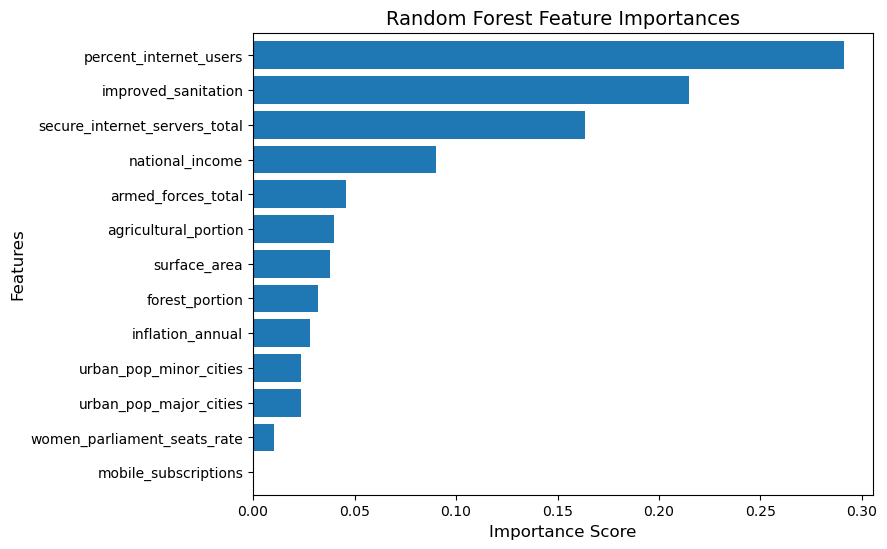

In [16]:
# Extract feature importances from the trained Random Forest model
feature_imp = pd.Series(
    rf.feature_importances_,  # Importance scores assigned by the Random Forest
    index=X.columns            # Associate each score with the corresponding feature name
)

# Sort feature importances in ascending order for better visualization
feature_imp.sort_values(ascending=True, inplace=True)  

# Plot feature importances as a horizontal bar chart
feature_imp.plot(
    kind='barh',   # Horizontal bar plot for easier reading
    width=0.8,     # Width of the bars
    figsize=(8,6)  # Figure size (width x height)
)

# Add title and axis labels
plt.title("Random Forest Feature Importances", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Display the plot
plt.show()

### Using scikit-learn for Hyperparameter Search

Scikit-learn provides built-in tools for systematic hyperparameter search for machine learning models, such as `ParameterGrid`, `GridSearchCV`, and `RandomizedSearchCV`. These tools help optimize model performance by finding the best combination of hyperparameters.

**Advantages of Using scikit-learn Hyperparameter Search:**

1. **Automation**  
   Automatically iterates over all possible (or random) combinations of hyperparameters, saving manual effort and reducing errors.

2. **Cross-Validation Integration**  
   Supports cross-validation to evaluate model performance robustly across different data splits, preventing overfitting to a single training set.

3. **Consistency**  
   Ensures reproducible results with options like `random_state`.

4. **Flexibility**  
   Works with any scikit-learn estimator, allowing custom scoring metrics (e.g., MAE, MSE, R²).

5. **Efficiency (with Randomized Search)**  
   `RandomizedSearchCV` can explore large hyperparameter spaces without exhaustively testing all combinations, saving computation time.

6. **Easy Integration with Pipelines**  
   Can be combined with preprocessing pipelines, scaling, and feature engineering steps for a streamlined workflow.

**Example Approaches:**

- `ParameterGrid`: Iterates manually over all hyperparameter combinations.  
- `GridSearchCV`: Performs exhaustive grid search with cross-validation.  
- `RandomizedSearchCV`: Randomly samples hyperparameters from the grid for faster optimization.


Best Hyperparameters: {'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}
Best Mean Absolute Error: 2.563


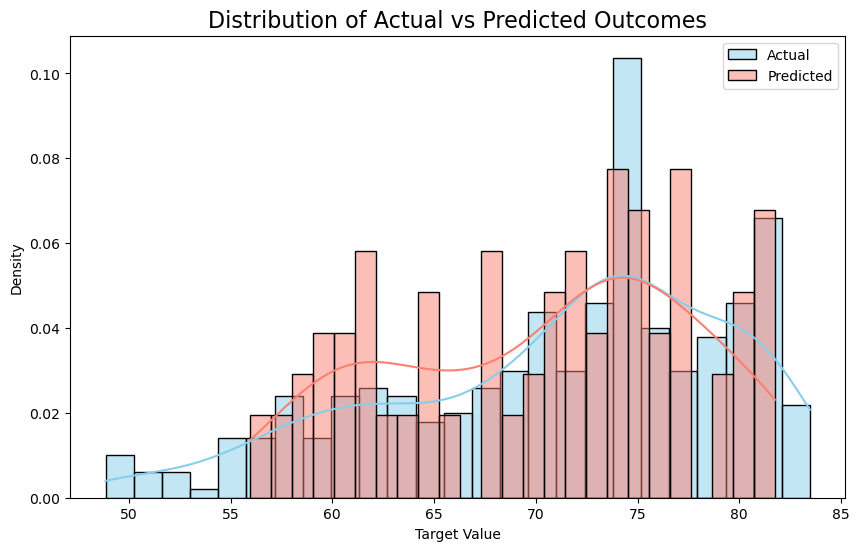

R-squared: 0.9375
Mean Absolute Error (MAE): 1.3500


In [17]:
# This code uses the scikit-learn package to perform a grid search over hyperparameters
# for a Random Forest Regressor and evaluates the model using cross-validation.

# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 125, 150, 175, 200],   # Number of trees in the forest
    'max_features': [2, 5, 7, 10, 13],           # Number of features to consider at each split
    'max_depth': [5, 6, 7, 8, 9, 10],            # Maximum depth of each tree
    'min_samples_split': [2, 3, 4, 5],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 3, 4, 5]             # Minimum number of samples required to be at a leaf node
}

# Initialize best score for comparison (lower MAE is better)
best_score = 100  
best_params = None  # To store the best hyperparameter combination

# Iterate over all combinations of hyperparameters using ParameterGrid
for params in ParameterGrid(param_grid):
    # Create Random Forest Regressor with current parameters
    rf = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        criterion="absolute_error",  # Use Mean Absolute Error as split criterion
        max_features=params['max_features'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=33,
        oob_score=False
    )
    
    # Fit the model on the full training dataset
    rf.fit(X, y)
    
    # Evaluate model performance using 4-fold cross-validation with MAE
    score = -np.mean(cross_val_score(rf, X, y, cv=4, scoring='neg_mean_absolute_error'))
    
    # Update best hyperparameters if current score is lower
    if score <= best_score:
        best_score = score
        best_params = params.copy()  # Store the best parameter combination

# Print the best hyperparameters and corresponding Mean Absolute Error
print("Best Hyperparameters:", best_params)
print("Best Mean Absolute Error: {:.3f}".format(best_score))

# --- Fit Random Forest using the best hyperparameters ---
rf_best = RandomForestRegressor(
    criterion='absolute_error',
    random_state=33,
    **best_params  # Unpack best hyperparameters
)
rf_best.fit(X, y)  # Train the model on the full dataset

# --- Predict on test dataset
y_test = rf_best.predict(tdf)

# Compare distributions of actual vs predicted values
plot_histogram_comp(y, y_test)

# Evaluate model on training set
y_pred = rf_best.predict(X)
r2 = r2_score(y, y_pred)  # Proportion of variance explained
mae = mean_absolute_error(y, y_pred)  # Average absolute prediction error
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

**Visualize the top 13 features and their feature importance.**

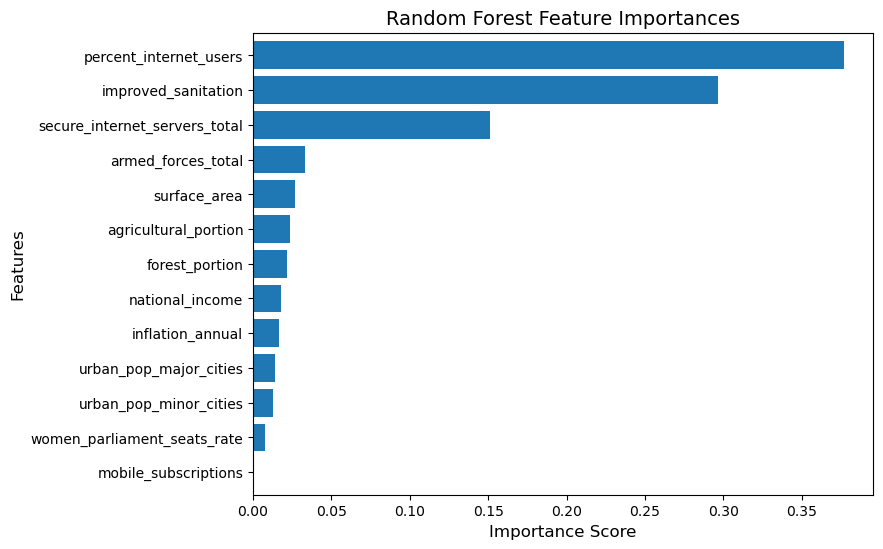

In [18]:
# Extract feature importances from the trained Random Forest model
feature_imp = pd.Series(
    rf.feature_importances_,  # Importance scores assigned by the Random Forest
    index=X.columns            # Associate each score with the corresponding feature name
)

# Sort feature importances in ascending order for better visualization
feature_imp.sort_values(ascending=True, inplace=True)  

# Plot feature importances as a horizontal bar chart
feature_imp.plot(
    kind='barh',   # Horizontal bar plot for easier reading
    width=0.8,     # Width of the bars
    figsize=(8,6)  # Figure size (width x height)
)

# Add title and axis labels
plt.title("Random Forest Feature Importances", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Display the plot
plt.show()

> #### Task:
- **The test dataset using your optimized model** <br/>
    For each record in the test set (`Test.csv`), you must predict the value of the `life_expectancy` variable. You should submit a CSV file with a header row and one row per test entry. The file (submissions.csv) should have exactly 2 columns:

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **life_expectancy**

In [ ]:
# Create submission_df and submission.csv
d = {'id':test_data.index, 'life_expectancy':y_test}
submission_df = pd.DataFrame(data= d)
submission_df.to_csv('life_expectancy_test.csv', index=False)